In [1]:
import sys
import os
sys.path.append(os.path.abspath("../.."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

from models.lstm import LSTMRegressor
from models.kan_encoder import KANEncoder
from utils.stock_data import get_data_loaders, StockIndex
from utils.early_stopping import EarlyStopping
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
window_size = 7
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

BEST_LSTM_PARAMS = {
    StockIndex.NVDA: {
        "hidden_dim": 352,
        "num_layers": 1,
        "dropout": 0.28541614143129757,
        "batch_size": 16,
        "lr": 0.00044517259602202056
    },
    StockIndex.AAPL: {
        "hidden_dim": 384,
        "num_layers": 1,
        "dropout": 0.22917171281782978,
        "batch_size": 16,
        "lr": 0.0026358901455780454
    },
    StockIndex.KO: {
        "hidden_dim": 480,
        "num_layers": 1,
        "dropout": 0.19466720673124002,
        "batch_size": 16,
        "lr": 0.0014651429936464527
    }
}

BEST_KAN_PARAMS = {
    StockIndex.NVDA: {
        "kan_hidden_dim": 13,
        "grid": 7,
        "k": 2,
        "lambda_reg": 0.00020923509152597237,
        "lamb_entropy": 1.4074233647718077,
        "lamb_l1": 0.7293519378519173,
        "lr": 0.004675641235511533
    },
    StockIndex.AAPL: {
        "kan_hidden_dim": 16,
        "grid": 21,
        "k": 2,
        "lambda_reg": 2.6715043789407973e-05,
        "lamb_entropy": 1.134403836291155,
        "lamb_l1": 0.5277577169538109,
        "lr": 0.009146560306086796
    },
    StockIndex.KO: {
        "kan_hidden_dim": 16,
        "grid": 21,
        "k": 2,
        "lambda_reg": 2.1348999901951964e-05,
        "lamb_entropy": 1.0408361292114134,
        "lamb_l1": 0.16533819011891496,
        "lr": 0.006586289317583112
    }
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Training KAN-Fixed LSTM for each stock ##

### NVIDIA ###
Avg Val Loss in Tuning 0.002179

In [3]:
stock = StockIndex.NVDA
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.008742244875515962
Epoch 2: Train=0.0004735867317349678
Epoch 3: Train=0.00032075288669662454
Epoch 4: Train=0.00042627748806615165
Epoch 5: Train=0.0006131271556380788
Epoch 6: Train=0.00038385896936454105
Epoch 7: Train=0.0002745981850367947
Epoch 8: Train=0.000545151904901499
Epoch 9: Train=0.00023012676698419107
Epoch 10: Train=0.000274680386160117
Epoch 11: Train=0.00028840096924933744
Epoch 12: Train=0.00022297350803244332
Epoch 13: Train=0.00029175033529155013
Epoch 14: Train=0.0004300806312948216
Epoch 15: Train=0.0002063366774389652
Epoch 16: Train=0.00032701675298434416
Epoch 17: Train=0.0003138443601648135
Epoch 18: Train=0.00027074521502145954
Epoch 19: Train=0.0002922007453081379
Epoch 20: Train=0.00027222702614968934
Epoch 21: Train=0.0001823217577901857
Epoch 22: Train=0.0002274878867011108
Epoch 23: Train=0.0002569087431251631
Epoch 24: Train=0.00028993331348333
Epoch 25: Train=0.00018323700511025504
Epoch 26: Train=0.0002215021554938442
Epoch 27: Train

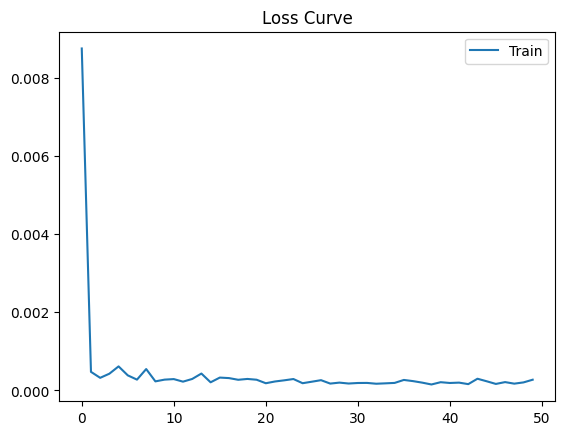

In [4]:
nvda_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

nvda_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    affine_trainable=False,
    symbolic_enabled=False,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': nvda_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': nvda_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    nvda_encoder.train()
    nvda_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = nvda_encoder(xb)
        preds = nvda_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = nvda_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 11.7806
Test MAE : 9.3259


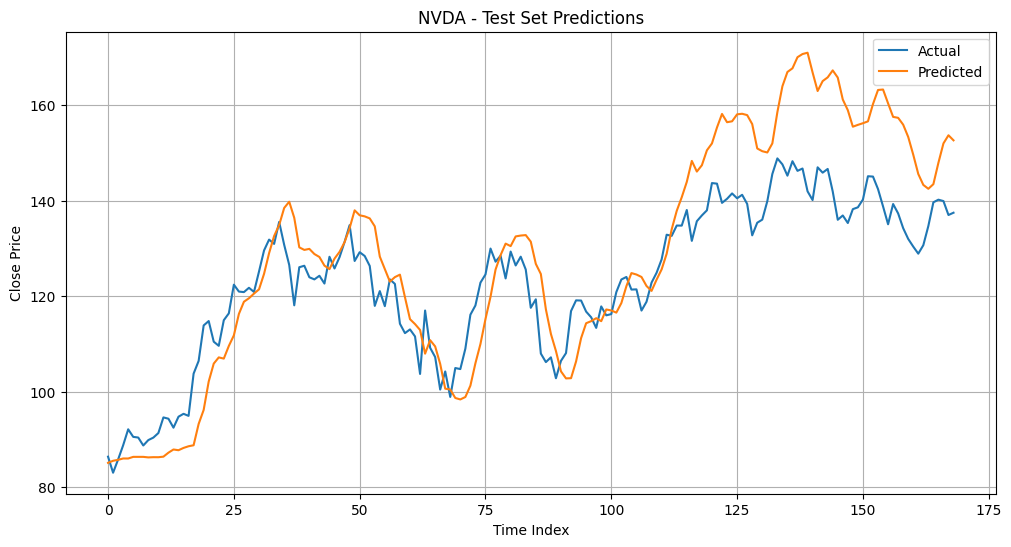

Actual Volatility (std of returns): 0.0328
Predicted Volatility             : 0.0219


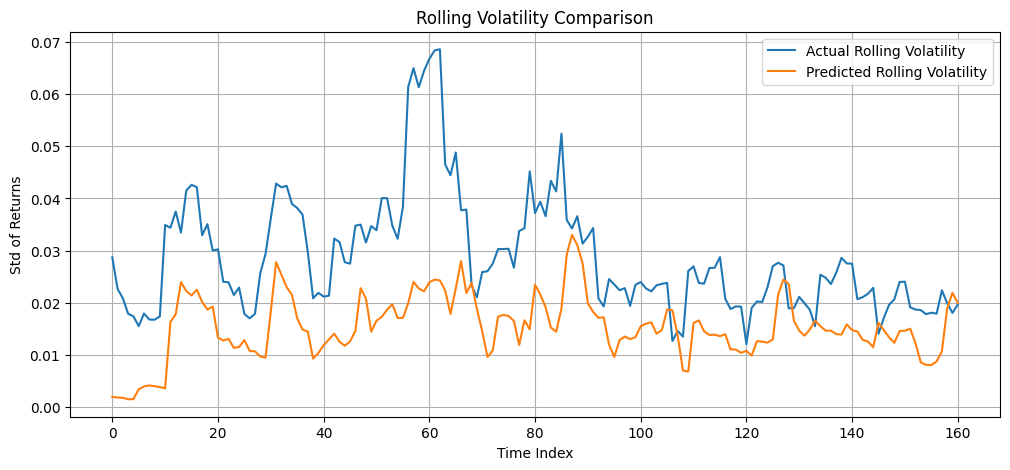

In [5]:
# Ensure both models are in eval mode
nvda_encoder.eval()
nvda_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = nvda_encoder(xb)             # [B, T, D]
        pred = nvda_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
nvda_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
nvda_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(nvda_targets_unscaled, nvda_preds_unscaled))
mae = mean_absolute_error(nvda_targets_unscaled, nvda_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(nvda_targets_unscaled, label="Actual")
plt.plot(nvda_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(nvda_targets_unscaled) / nvda_targets_unscaled[:-1]
pred_returns   = np.diff(nvda_preds_unscaled) / nvda_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

### Apple ###
Avg Val Loss in Tuning 0.000333

In [6]:
stock = StockIndex.AAPL
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.010085007583991756
Epoch 2: Train=0.000510775038032943
Epoch 3: Train=0.0004981830820495337
Epoch 4: Train=0.0005658315831996416
Epoch 5: Train=0.00037234466391523847
Epoch 6: Train=0.0002950599920233909
Epoch 7: Train=0.0003412186798055755
Epoch 8: Train=0.00035306485149317956
Epoch 9: Train=0.0002707935381102178
Epoch 10: Train=0.0002845494494646449
Epoch 11: Train=0.0002718378532198117
Epoch 12: Train=0.00034717886757624166
Epoch 13: Train=0.00026993789416714336
Epoch 14: Train=0.00047187678402141586
Epoch 15: Train=0.00047833795337044076
Epoch 16: Train=0.00029071648664698427
Epoch 17: Train=0.00025503198838748055
Epoch 18: Train=0.0003784854613853656
Epoch 19: Train=0.000292409608929037
Epoch 20: Train=0.0002809251116816839
Epoch 21: Train=0.0002965286301773493
Epoch 22: Train=0.00034222178874188103
Epoch 23: Train=0.0002789549089908233
Epoch 24: Train=0.0002806869330989418
Epoch 25: Train=0.0003053180906209316
Epoch 26: Train=0.0002983507045869236
Epoch 27: Train

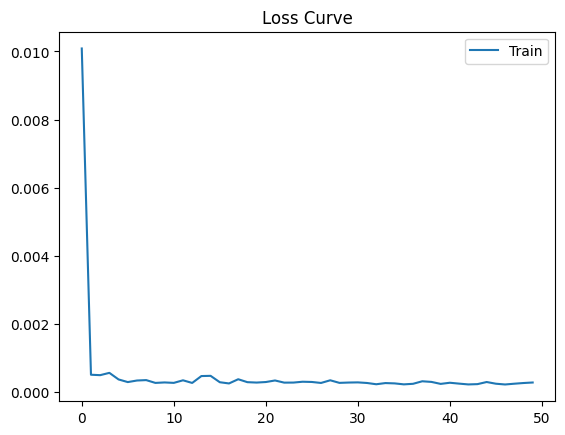

In [7]:
aapl_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

aapl_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    symbolic_enabled=False,
    affine_trainable=False,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': aapl_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': aapl_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    aapl_encoder.train()
    aapl_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = aapl_encoder(xb)
        preds = aapl_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = aapl_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 33.8539
Test MAE : 30.9013


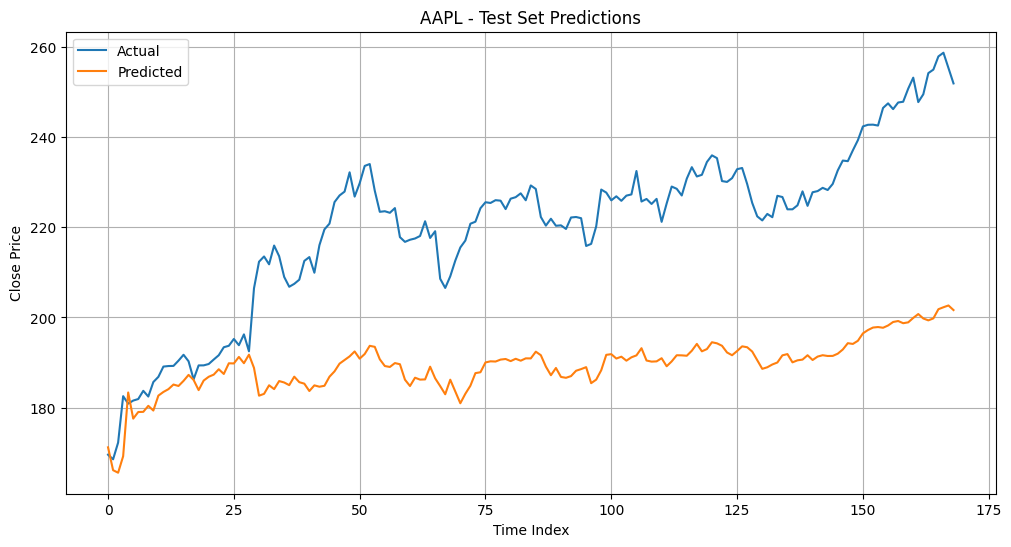

Actual Volatility (std of returns): 0.0145
Predicted Volatility             : 0.0106


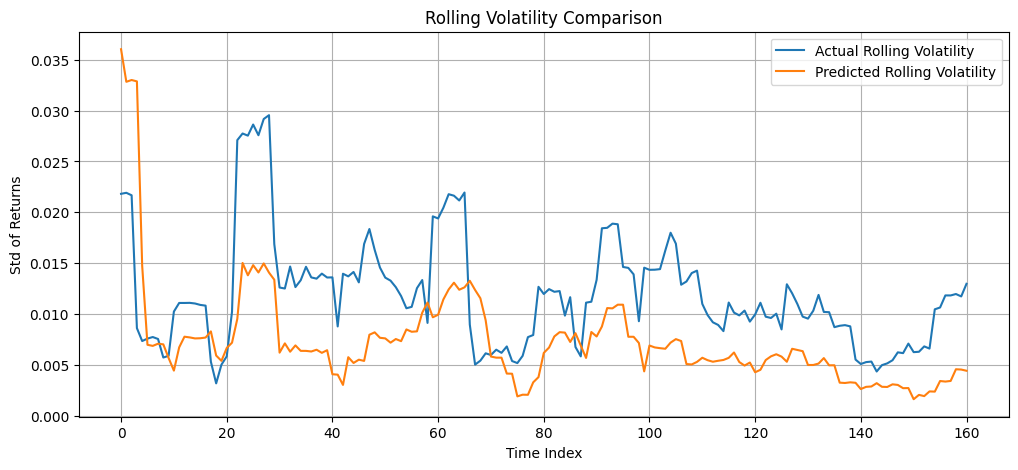

In [8]:
# Ensure both models are in eval mode
aapl_encoder.eval()
aapl_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = aapl_encoder(xb)             # [B, T, D]
        pred = aapl_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
aapl_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
aapl_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(aapl_targets_unscaled, aapl_preds_unscaled))
mae = mean_absolute_error(aapl_targets_unscaled, aapl_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(aapl_targets_unscaled, label="Actual")
plt.plot(aapl_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(aapl_targets_unscaled) / aapl_targets_unscaled[:-1]
pred_returns   = np.diff(aapl_preds_unscaled) / aapl_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

### Coke ###
Avg Val Loss in Tuning 0.000383

In [9]:
stock = StockIndex.KO
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.015470520706701497
Epoch 2: Train=0.0007419461218905964
Epoch 3: Train=0.0014445151113011319
Epoch 4: Train=0.0006520515221060545
Epoch 5: Train=0.0006467261221706679
Epoch 6: Train=0.0005140168068464845
Epoch 7: Train=0.0005921356263423499
Epoch 8: Train=0.0005131134555517517
Epoch 9: Train=0.0006013075923112061
Epoch 10: Train=0.0004469155159901188
Epoch 11: Train=0.0005594836822840282
Epoch 12: Train=0.00044041214821827267
Epoch 13: Train=0.00038493080537959067
Epoch 14: Train=0.00036743057797947485
Epoch 15: Train=0.00038914716189005177
Epoch 16: Train=0.0004163682361567308
Epoch 17: Train=0.0004018831814667492
Epoch 18: Train=0.0005083503020807367
Epoch 19: Train=0.0005807118340997458
Epoch 20: Train=0.0003776125299139889
Epoch 21: Train=0.0004109464644723704
Epoch 22: Train=0.0004149477169972449
Epoch 23: Train=0.00044690137130803324
Epoch 24: Train=0.00035144224562423513
Epoch 25: Train=0.00046632907146381005
Epoch 26: Train=0.00041697446402101163
Epoch 27: Trai

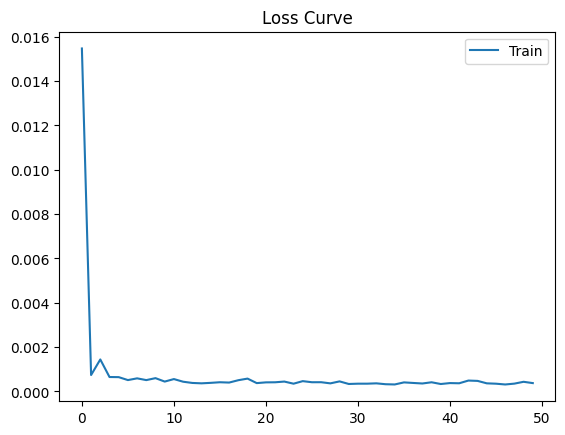

In [10]:
ko_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

ko_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    symbolic_enabled=False,
    affine_trainable=False,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': ko_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': ko_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []
val_losses = []

best_val_loss = float("inf")
best_model_state = None

for epoch in range(50):
    ko_encoder.train()
    ko_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = ko_encoder(xb)
        preds = ko_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = ko_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 6.7559
Test MAE : 5.9928


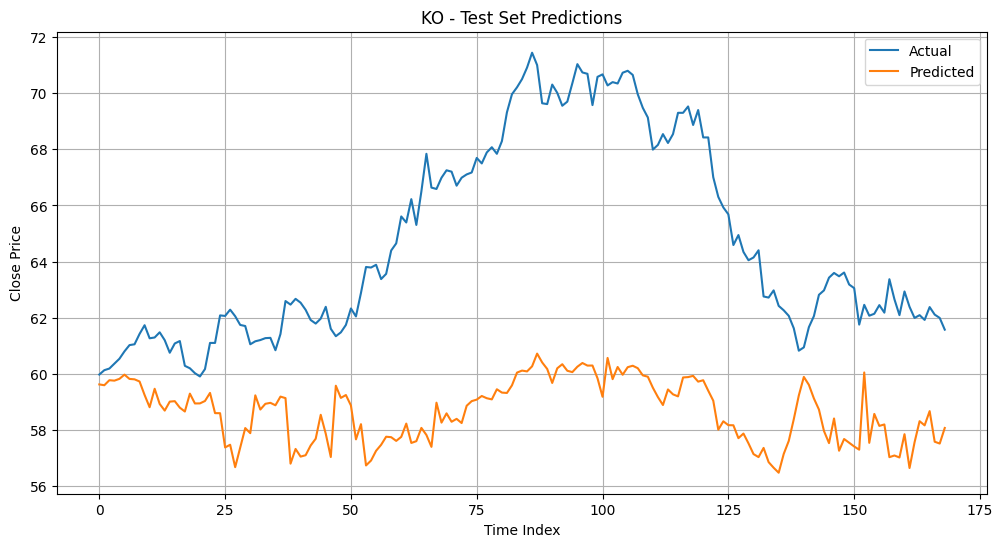

Actual Volatility (std of returns): 0.0083
Predicted Volatility             : 0.0109


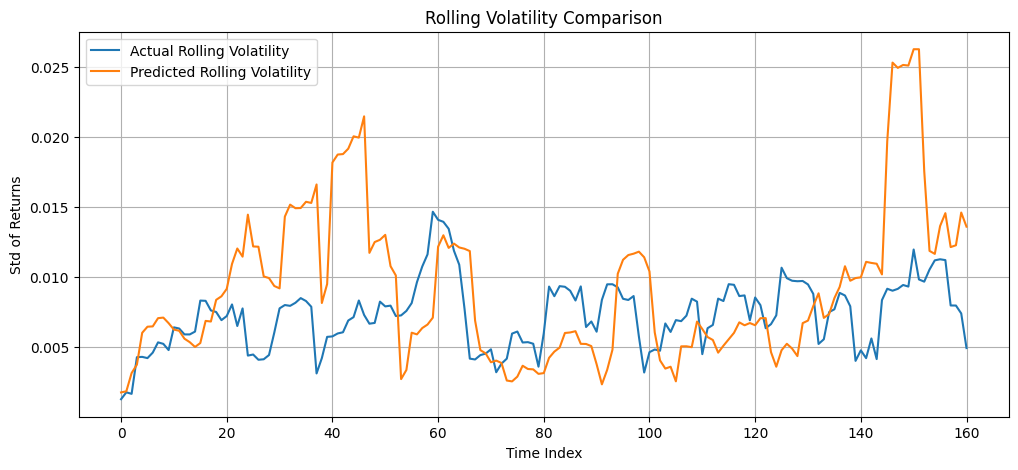

In [11]:
# Ensure both models are in eval mode
ko_encoder.eval()
ko_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = ko_encoder(xb)             # [B, T, D]
        pred = ko_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
ko_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
ko_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(ko_targets_unscaled, ko_preds_unscaled))
mae = mean_absolute_error(ko_targets_unscaled, ko_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(ko_targets_unscaled, label="Actual")
plt.plot(ko_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(ko_targets_unscaled) / ko_targets_unscaled[:-1]
pred_returns   = np.diff(ko_preds_unscaled) / ko_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()